In [3]:
import numpy as np  # For numerical operations
import pandas as pd  # For handling dataset metadata (like CSV files)
import os  # For file and directory operations
import matplotlib.pyplot as plt  # For data visualization


In [2]:
pip install pandas

  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
    --------------------------------------- 0.3/11.6 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.6 MB 1.5 MB/s eta 0:00:08
   --- ------------------------------------ 1.0/11.6 MB 1.5 MB/s eta 0:00:07
   ---- ----------------------------------- 1.3/11.6 MB 1.6 MB/s eta 0:00:07
   ------ --------------------------------- 1.8/11.6 MB 1.7 MB/s eta 0:00:06
   -------- ------------------------------- 2.4/11.6 MB 1.8 MB/s eta 0:00:06
   ---------- ----------------------------- 3.1/11.6 MB 2.1 MB/s eta 0:00:05
   ------------- -------------------------- 3.9/11.6 MB 2.3 MB/s eta 0:00:04
   ---------------- ----------------------- 4.7/11.6 MB 2.4 MB/s eta 0:00:03
   ------------------ --------------------- 5.2/11.6 MB 2.5 MB/s eta 0:00:03
   ------------

In [7]:
from tensorflow.keras.utils import to_categorical


In [8]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

# Initialize variables
INIT_LR = 1e-4  # Initial learning rate
EPOCHS = 20  # Number of epochs to train
BS = 32  # Batch size

# Path to the dataset (tiger images and non-tiger images)
DIRECTORY = r"D:\Deep Learning\Object detection\dataset"
CATEGORIES = ["tiger", "non_tiger"]

# Initialize the data and labels
data = []
labels = []



In [ ]:
# Loop over the image paths and process them
for category in CATEGORIES:
    categoryPath = os.path.join(DIRECTORY, category)
    for imagePath in list(paths.list_images(categoryPath)):
        # Load the image, convert it to an array, and preprocess it
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        # Append the image and label
        data.append(image)
        labels.append(category)

# Convert data and labels to numpy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# Perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# Split the data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

# Initialize the image data generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

# Load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)  # 2 classes: tiger, non-tiger

# Place the head FC model on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)

# Freeze the layers of MobileNetV2 to prevent them from being updated during the first training phase
for layer in baseModel.layers:
    layer.trainable = False

# Compile the model
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train the model
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)



Epoch 1/20
41/41 [==============================] - 31s 703ms/step - loss: 0.1150 - accuracy: 0.9784 - val_loss: 0.0611 - val_accuracy: 0.9940
Epoch 2/20
41/41 [==============================] - 28s 671ms/step - loss: 0.0353 - accuracy: 0.9954 - val_loss: 0.0590 - val_accuracy: 0.9940
Epoch 3/20
41/41 [==============================] - 28s 670ms/step - loss: 0.0312 - accuracy: 0.9961 - val_loss: 0.0541 - val_accuracy: 0.9940
Epoch 4/20
41/41 [==============================] - 27s 659ms/step - loss: 0.0322 - accuracy: 0.9954 - val_loss: 0.0507 - val_accuracy: 0.9940
Epoch 5/20
41/41 [==============================] - 29s 699ms/step - loss: 0.0326 - accuracy: 0.9954 - val_loss: 0.0463 - val_accuracy: 0.9940
Epoch 6/20
41/41 [==============================] - 28s 686ms/step - loss: 0.0254 - accuracy: 0.9954 - val_loss: 0.0404 - val_accuracy: 0.9940
Epoch 7/20
41/41 [==============================] - 28s 690ms/step - loss: 0.0213 - accuracy: 0.9961 - val_loss: 0.0386 - val_accuracy: 0.9940

In [10]:
# Evaluate the model on the test set
predIdxs = model.predict(testX, batch_size=BS)

# For each image in the test set, find the index of the label with the largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# Print a classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))


11/11 [==============================] - 5s 431ms/step
              precision    recall  f1-score   support

   non_tiger       0.00      0.00      0.00         2
       tiger       0.99      1.00      1.00       330

    accuracy                           0.99       332
   macro avg       0.50      0.50      0.50       332
weighted avg       0.99      0.99      0.99       332



C:\anaconda\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\anaconda\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\anaconda\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:

# Save the model
model.save("tiger_detection_model.h5")
print("Model saved as tiger_detection_model.h5")

Model saved as tiger_detection_model.h5


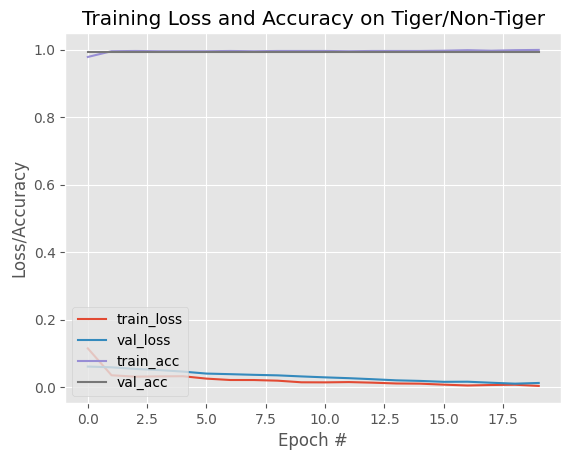

In [11]:

# Plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Tiger/Non-Tiger")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")
